In [1]:
from google.colab import drive
drive.mount('/content/drive')
!pip install mplfinance

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 70 kB 7.4 MB/s 


In [45]:
import tensorflow as tf
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import matplotlib.dates as mpl_dates
import datetime
from mplfinance.original_flavor import candlestick_ohlc
from sklearn.model_selection import train_test_split
from keras.layers import *
from keras.models import *
from keras.callbacks import *
from keras.optimizers import *

plt.style.use('ggplot')

In [31]:
#initialising arrays to store the date the open price close price high and low
Date_array=[]
Open_price_array=[]
Close_price_array=[]
Highs_array=[]
Lows_array=[]
with open('/content/drive/Shareddrives/SoC 2022/RELIANCE.NS.csv', 'r') as file:
  reader = csv.reader(file)
  for row in reader:
      Date_array+=[row[0]]
      Open_price_array+=[row[1]]
      Highs_array+=[row[2]]
      Lows_array+=[row[3]]
      Close_price_array+=[row[4]]

In [32]:
# Params
period = 5


In [33]:
itr = 1
out_arr = []
while(period*itr + 1< len(Date_array)):
  # if period*itr + 1 > len(Date_array):
  #   break
  # else:
  if Close_price_array[period*itr - 1] > Close_price_array[period*itr]:
    out_arr.append(0)
  else:
    out_arr.append(1)
  itr += 1

exp_out = np.array(out_arr)
print(exp_out.shape)

(639,)


In [34]:
print(exp_out[101])

0


In [35]:
#splitting the data into period of 20 days so that we could plot in groups of 20 and then save that data as images locally
#setting the period here in case we want to change the period for which we want to take images of the candlestick data
#using a while loop that will break out once there are less than 20 days to put in a graph
iterator = 0
while(True):
    if (iterator+1)*period>len(Date_array):
        break
    
    # Defining a dataframe showing stock prices 
    # of a week
    stock_prices = pd.DataFrame({'date': np.array([datetime.datetime.strptime(Date_array[iterator*period+i+1], '%Y-%m-%d') for i in range(period)]),
                                'open': Open_price_array[1+iterator*period:period+1+iterator*period],
                                'close': Close_price_array[1+iterator*period:period+1+iterator*period],
                                'high': Highs_array[1+iterator*period:period+1+iterator*period],
                                'low': Lows_array[1+iterator*period:period+1+iterator*period]})
    
    ohlc = stock_prices.loc[:, ['date', 'open', 'high', 'low', 'close']]
    ohlc['date'] = pd.to_datetime(ohlc['date'])
    ohlc['date'] = ohlc['date'].apply(mpl_dates.date2num)
    ohlc = ohlc.astype(float)
    
    # Creating Subplots
    fig, ax = plt.subplots()
    
    candlestick_ohlc(ax, ohlc.values, width=0.6, colorup='green',
                    colordown='red', alpha=0.8)
  
    # Formatting Date
    date_format = mpl_dates.DateFormatter('%d-%m-%Y')
    ax.xaxis.set_major_formatter(date_format)
    fig.autofmt_xdate()
    
    fig.tight_layout()

    path_of_file = "/content/drive/Shareddrives/SoC 2022/stock_charts/" + str(iterator+1)+ ".png"

    plt.savefig(path_of_file)
    plt.close()
    iterator+=1

In [36]:
from skimage.io import imread, imshow, show
from skimage.transform import resize

img_height = 64
img_width = 64
img_channels = 3

dir_path_img = "/content/drive/Shareddrives/SoC 2022/stock_charts/"
images = next(os.walk(dir_path_img))[2]

imgs = np.zeros((len(images), img_height, img_width, img_channels), dtype = np.uint8)

# image resizing
for i in range(1, len(images)):
    s = str(i)
    img = imread(dir_path_img + s + ".png")
    img = resize(img, (img_height, img_width, img_channels), mode = 'constant', preserve_range = True)
    imgs[i - 1] = img

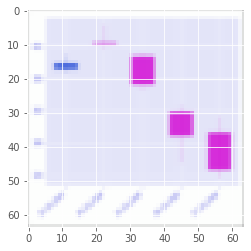

In [60]:
plt.imshow(imgs[0])

In [61]:
# input layer
model = Sequential()
model.add(Input((img_height, img_width, img_channels)))
model.add(Conv2D(32, (3,3), activation = 'relu', kernel_initializer = 'glorot_uniform', padding = 'same'))
model.add(MaxPooling2D((2,2)))
# model.add(tf.keras.layers.BatchNormalization())
model.add(Conv2D(48, (3,3), activation = 'relu', kernel_initializer = 'glorot_uniform', padding = 'same'))
model.add(MaxPooling2D((2,2)))
# model.add(tf.keras.layers.BatchNormalization())
model.add(Dropout(0.5))
model.add(Conv2D(64, (3,3), activation = 'relu', kernel_initializer = 'glorot_uniform', padding = 'same'))
model.add(MaxPooling2D((2,2)))
# model.add(tf.keras.layers.BatchNormalization())
model.add(Conv2D(96, (3,3), activation = 'relu', kernel_initializer = 'glorot_uniform', padding = 'same'))
model.add(MaxPooling2D((2,2)))
# model.add(tf.keras.layers.BatchNormalization())
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256))
model.add(Dropout(0.5))
# model.add(Dense(2))
model.add(Dense(1))

In [62]:
model.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy'])

In [63]:
model.fit(imgs[:-1], exp_out, validation_split = 0.1, batch_size = 64, epochs = 300, shuffle=True)

Epoch 1/300
9/9 [==============================] - 1s 48ms/step - loss: 7.6185 - accuracy: 0.5043 - val_loss: 8.4355 - val_accuracy: 0.4531
Epoch 2/300
9/9 [==============================] - 0s 20ms/step - loss: 6.8444 - accuracy: 0.5548 - val_loss: 6.9098 - val_accuracy: 0.5469
Epoch 3/300
9/9 [==============================] - 0s 22ms/step - loss: 7.3515 - accuracy: 0.5165 - val_loss: 6.9098 - val_accuracy: 0.5469
Epoch 4/300
9/9 [==============================] - 0s 19ms/step - loss: 7.2931 - accuracy: 0.5217 - val_loss: 6.9098 - val_accuracy: 0.5469
Epoch 5/300
9/9 [==============================] - 0s 21ms/step - loss: 7.2931 - accuracy: 0.5217 - val_loss: 6.9098 - val_accuracy: 0.5469
Epoch 6/300
9/9 [==============================] - 0s 19ms/step - loss: 7.2931 - accuracy: 0.5217 - val_loss: 6.9098 - val_accuracy: 0.5469
Epoch 7/300
9/9 [==============================] - 0s 25ms/step - loss: 7.2931 - accuracy: 0.5217 - val_loss: 6.9098 - val_accuracy: 0.5469
Epoch 8/300
9/9 [===